# Credit Card Fraud Detection Using Autoencoder

## Deep learning

Итак, мы добрались и до глубокого обучения. Все указанные выше классические методы были довольно требовательны: нам приходилось усердно работать с данными и параметрами самих моделей, чтобы добиться результата. Есть ли альтернатива?

### Автокодировщик

<img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/autoencoder.jpeg?w=638&ssl=1" width=800>

Как видно из рисунка, автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.

Как мы можем использовать автокодировщик для обнаружения мошеннических транзакций? Автокодировщиком мы пытаемся оптимизировать модель (то есть параметры модели), чтобы минимизировать ошибку реконструкции.

Теперь предположим, что мы подаем цифру 5 и на выходе получаем восстановленную цифру 5 с минимальной ошибкой восстановления. Теперь попробуем скормить другую цифру, которая пытается имитировать 5, когда мы получим на выходах ее восстановленную версию, она будет с большой ошибкой реконструкции. Это логика использования автокодировщика для обнаружения мошенничества. На вход подаем вектор из признаков (30 признаков).

## Declare required dependencies

In [ ]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

## Data ingestion

In [ ]:
url = "https://raw.githubusercontent.com/KoJl9lH-59rus/ML_KT/refs/heads/main/%D0%9A%D0%A21/content/transaction_dataset.csv"
df = pd.read_csv(url)

## Data exploration

In [ ]:
df.head(5)

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [ ]:
print(df.shape)
print(df.describe())

(9841, 51)
        Unnamed: 0        Index         FLAG  Avg min between sent tnx  \
count  9841.000000  9841.000000  9841.000000               9841.000000   
mean   4920.000000  1815.049893     0.221421               5086.878721   
std    2840.996333  1222.621830     0.415224              21486.549974   
min       0.000000     1.000000     0.000000                  0.000000   
25%    2460.000000   821.000000     0.000000                  0.000000   
50%    4920.000000  1641.000000     0.000000                 17.340000   
75%    7380.000000  2601.000000     0.000000                565.470000   
max    9840.000000  4729.000000     1.000000             430287.670000   

       Avg min between received tnx  Time Diff between first and last (Mins)  \
count                   9841.000000                             9.841000e+03   
mean                    8004.851184                             2.183333e+05   
std                    23081.714801                             3.229379e+05   
mi

## Ести ли пропуски?

In [ ]:
df.isnull().values.any()

True

Уберем все нечисловые значения

In [ ]:
df_numeric = df.select_dtypes(include=[np.number])

Заполним пустые значения числовых столбцов средним.

In [ ]:
df_numeric.fillna(df_numeric.mean(), inplace=True)

In [ ]:
df_numeric = df_numeric.drop(['Index'], axis=1)

KeyError: "['Index'] not found in axis"

In [ ]:
df_numeric = df_numeric.drop(['Unnamed: 0'], axis=1)

In [ ]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 46 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841

## Class distribution ( 0 - обычная, 1 - мошенническая)

In [ ]:
df_numeric['FLAG'].value_counts()

,count
FLAG,
0,7662
1,2179


<ipython-input-61-0b4e13eb743d>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['FLAG'], sort = True)


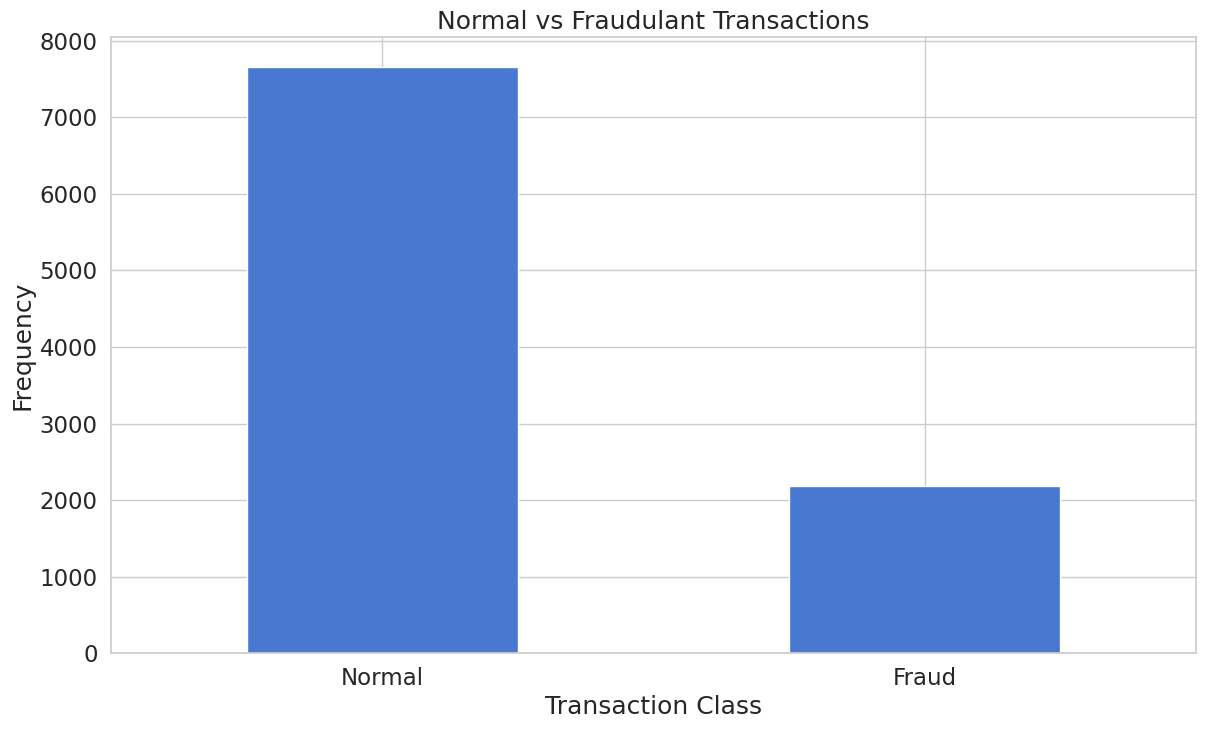

In [ ]:
count_classes = pd.value_counts(df['FLAG'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Normal vs Fraudulant Transactions")
plt.xticks(range(2), LABELS)
plt.xlabel("Transaction Class")
plt.ylabel("Frequency");

Наш набор данных очень сильно несбалансирован в пользу отрицательного (0, то есть нормального) класса. Это требует дальнейшего изучения данных

In [ ]:
fraudsDF = df[df.FLAG == 1]
normalDF = df[df.FLAG == 0]

In [ ]:
fraudsDF.shape

(2179, 51)

In [ ]:
normalDF.shape

(7662, 51)

Давайте теперь посмотрим на количество транзакций, задействованную в двух классах.

In [ ]:
fraudsDF['total transactions (including tnx to create contract'].describe()

,total transactions (including tnx to create contract
count,2179.000000
mean,29.042680
std,256.326956
min,0.000000
25%,1.000000
50%,5.000000
75%,16.000000
max,10000.000000


In [ ]:
normalDF['total transactions (including tnx to create contract'].describe()

,total transactions (including tnx to create contract
count,7662.000000
mean,355.688463
std,1518.850339
min,1.000000
25%,4.000000
50%,11.000000
75%,85.000000
max,19995.000000


Graphically speaking ...`

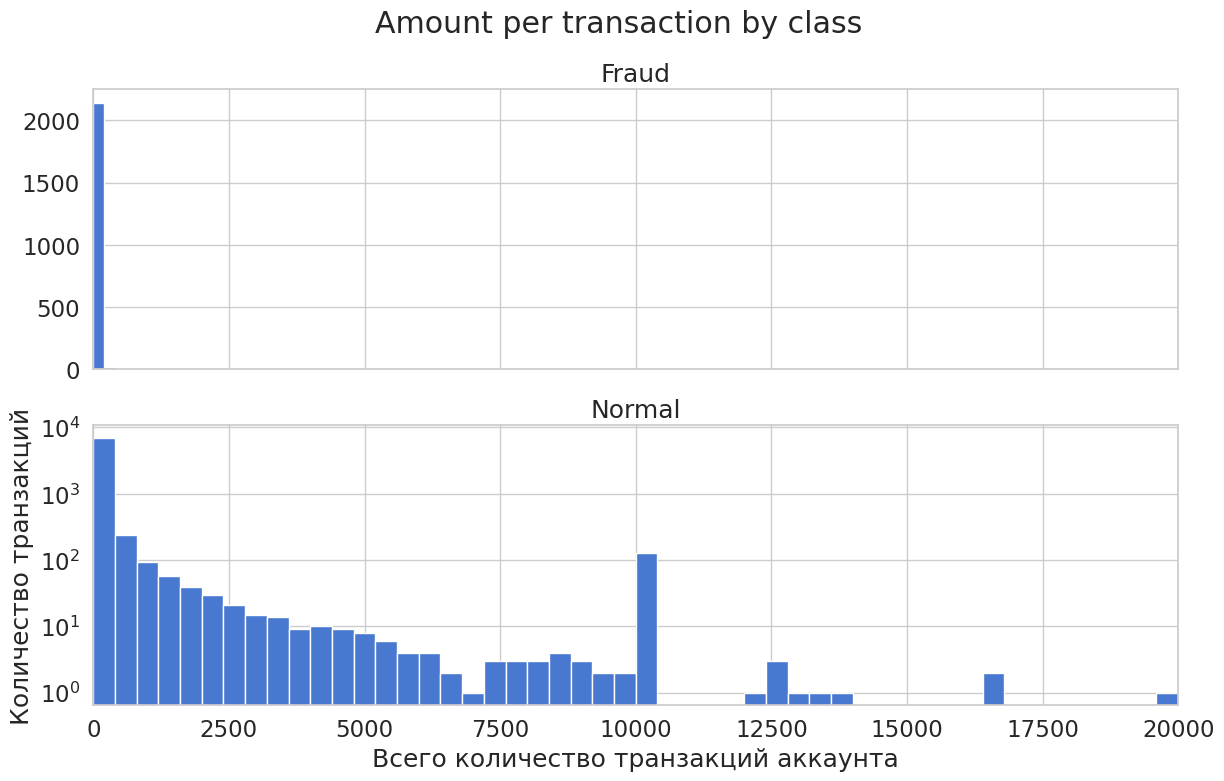

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraudsDF['total transactions (including tnx to create contract'], bins = bins)
ax1.set_title('Fraud')

ax2.hist(normalDF['total transactions (including tnx to create contract'], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Всего количество транзакций аккаунта')
plt.ylabel('Количество транзакций')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Влияет ли время транзакции на мошеннические транзакции?

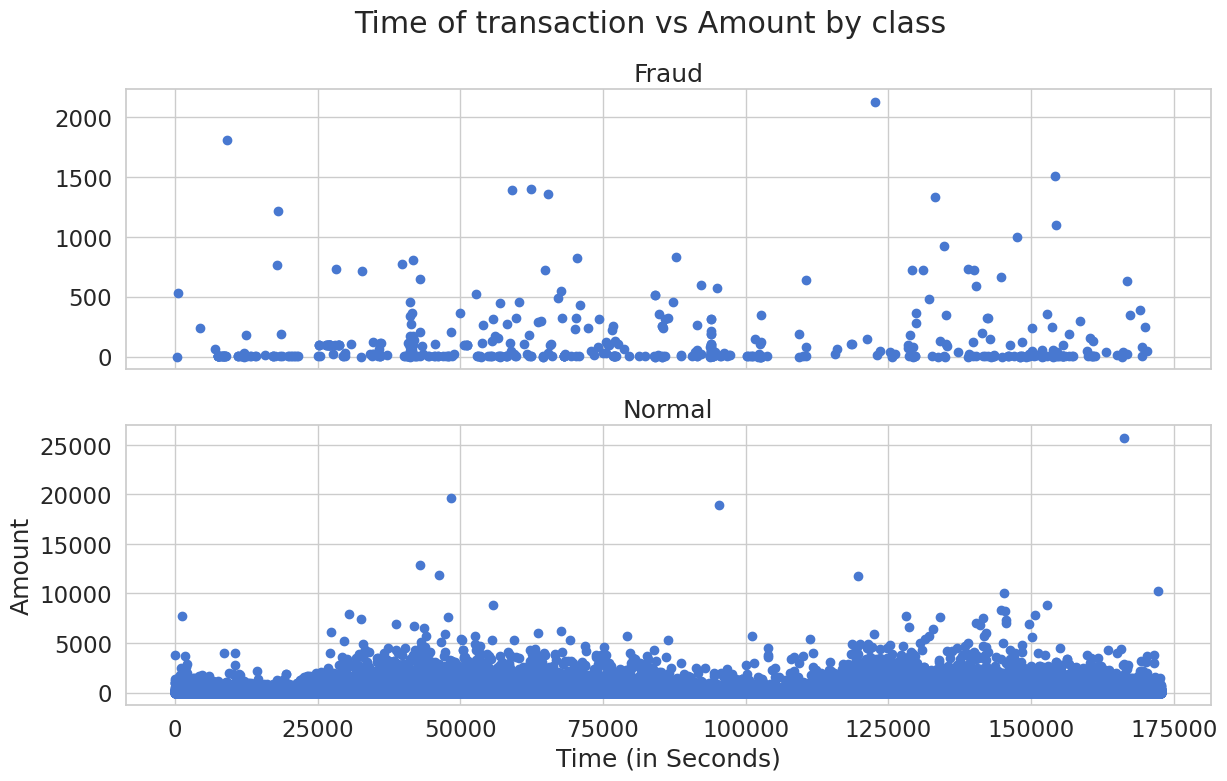

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraudsDF.Time, fraudsDF.Amount)
ax1.set_title('Fraud')

ax2.scatter(normalDF.Time, normalDF.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Таким образом, очевидно, что время транзакции не имеет никакого отношения к мошеннической деятельности.

## Preprocessing

Поскольку, как показано выше, время транзакции не влияет на мошенническую деятельность, эта функция не будет способствовать обучению модели. Следовательно, мы можем отказаться от него.

In [ ]:
transactionData = df.drop(['Time'], axis=1)

Также давайте стандартизируем Amount.

In [ ]:
transactionData['Amount'] = StandardScaler().fit_transform(transactionData['Amount'].values.reshape(-1, 1))

### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 80% и тест = 20%. В обучающем наборе данных будут только обычные транзакции, а в тестовом наборе данных будут как обычные, так и мошеннические транзакции.

In [ ]:
X_train, X_test = train_test_split(transactionData, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
#print(type(X_train))
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values
print(y_test.size)


56962


## Model
Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с 14,7,7,29 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер. Обратите внимание, что последний слой имеет 29 узлов, соответствующих 29 функциям в элементе входных данных.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(7, 7),
           nn.Tanh(),
           nn.Linear(7, 29),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Autoencoder().double()
#model = Autoencoder().double().cpu()

In [ ]:
num_epochs = 100   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32
learning_rate = 1e-3

**minibatch_size** - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов  мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик.
По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.


**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [ ]:

train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)


In [ ]:

#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)


In [ ]:
history = {}
history['train_loss'] = []
history['test_loss'] = []


In [ ]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/100], loss:0.7916
epoch [2/100], loss:0.7297
epoch [3/100], loss:0.7217
epoch [4/100], loss:0.7168
epoch [5/100], loss:0.7139
epoch [6/100], loss:0.7120
epoch [7/100], loss:0.7107
epoch [8/100], loss:0.7098
epoch [9/100], loss:0.7089
epoch [10/100], loss:0.7083
epoch [11/100], loss:0.7074
epoch [12/100], loss:0.7070
epoch [13/100], loss:0.7067
epoch [14/100], loss:0.7065
epoch [15/100], loss:0.7055
epoch [16/100], loss:0.7043
epoch [17/100], loss:0.7034
epoch [18/100], loss:0.7030
epoch [19/100], loss:0.7027
epoch [20/100], loss:0.7026
epoch [21/100], loss:0.7022
epoch [22/100], loss:0.7024
epoch [23/100], loss:0.7023
epoch [24/100], loss:0.7022
epoch [25/100], loss:0.7020
epoch [26/100], loss:0.7023
epoch [27/100], loss:0.7020
epoch [28/100], loss:0.7021
epoch [29/100], loss:0.7019
epoch [30/100], loss:0.7020
epoch [31/100], loss:0.7021
epoch [32/100], loss:0.7018
epoch [33/100], loss:0.7018
epoch [34/100], loss:0.7019
epoch [35/100], loss:0.7019
epoch [36/100], loss:0.7019
e

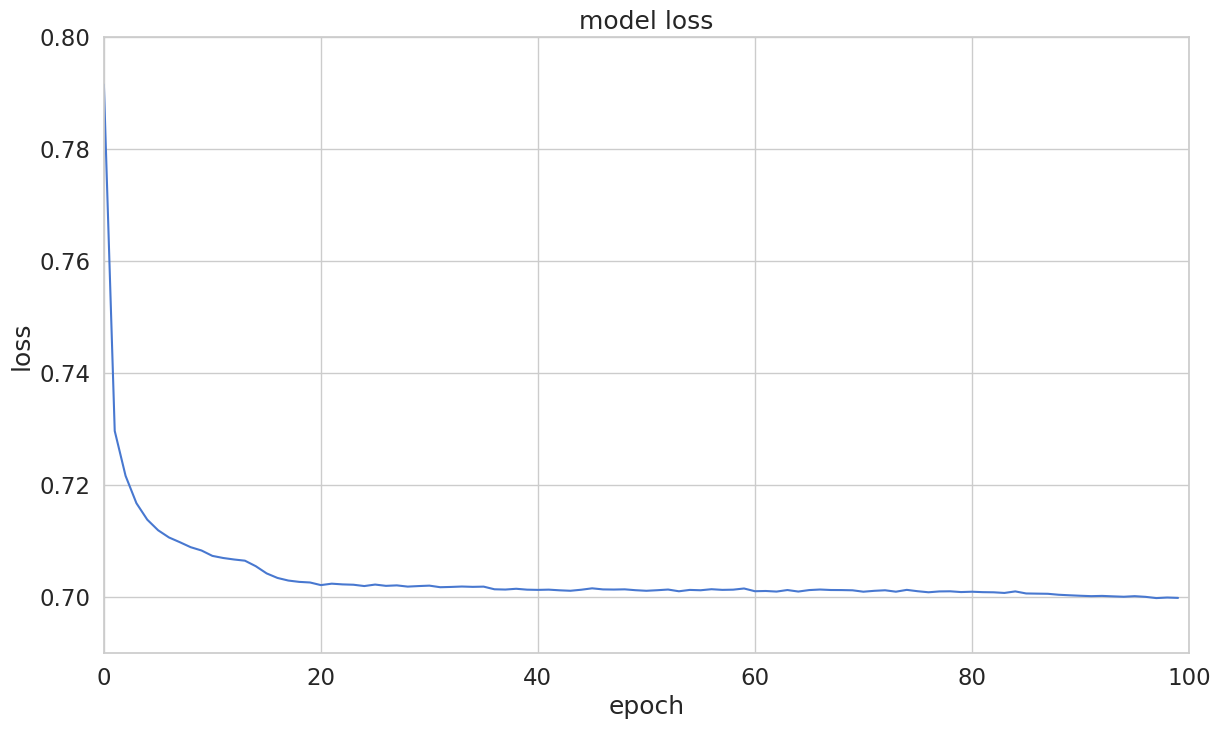

In [ ]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,0.69,0.80])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

## Оценка модели

In [ ]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

In [ ]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,56962.000000,56962.000000
mean,0.729916,0.001720
std,3.434292,0.041443
min,0.032078,0.000000
25%,0.238821,0.000000
50%,0.380336,0.000000
75%,0.604880,0.000000
max,260.680023,1.000000


In [ ]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,56962.000000,56962.000000
mean,0.729916,0.001720
std,3.434292,0.041443
min,0.032078,0.000000
25%,0.238821,0.000000
50%,0.380336,0.000000
75%,0.604880,0.000000
max,260.680023,1.000000


# Reconstruction Errors without Fraud

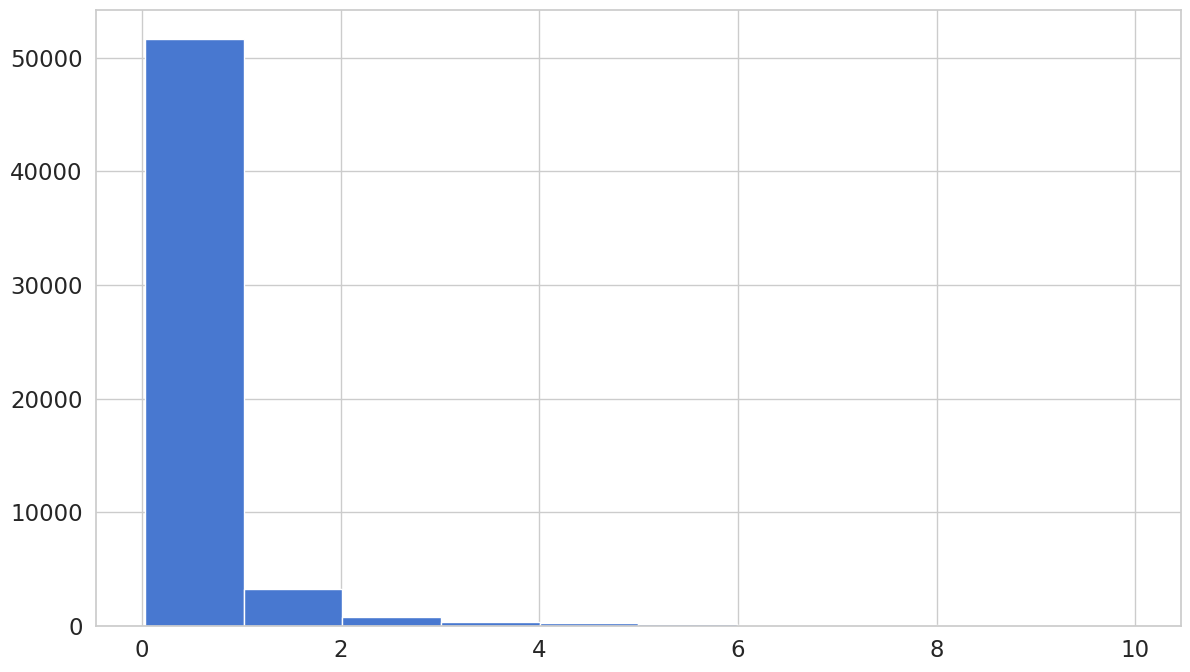

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with Fraud

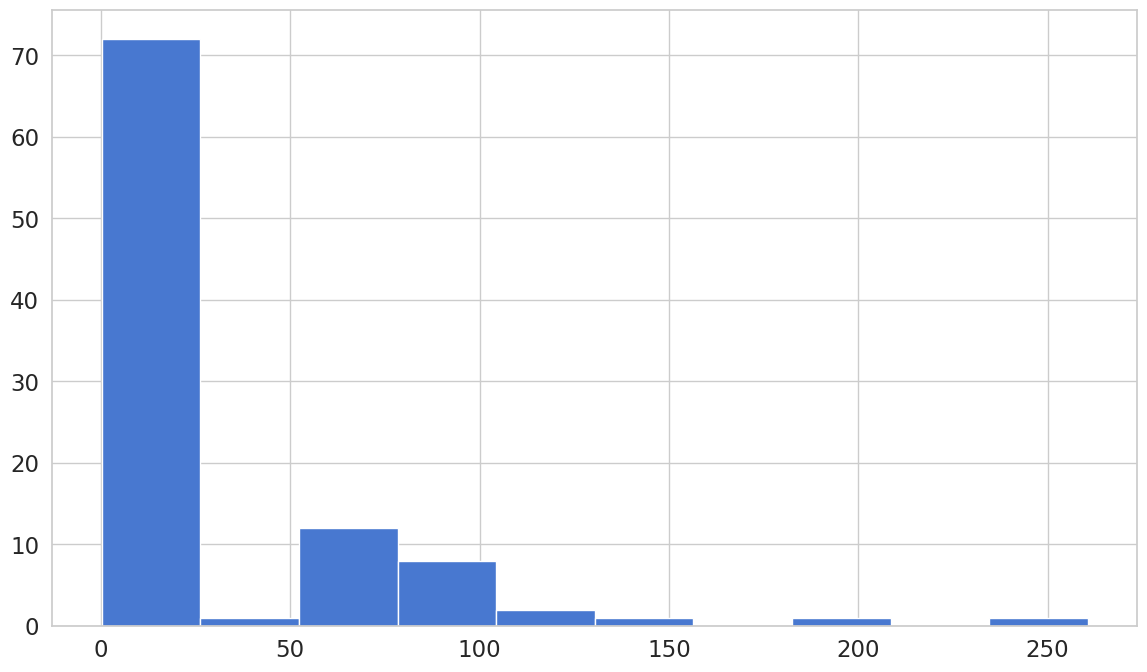

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

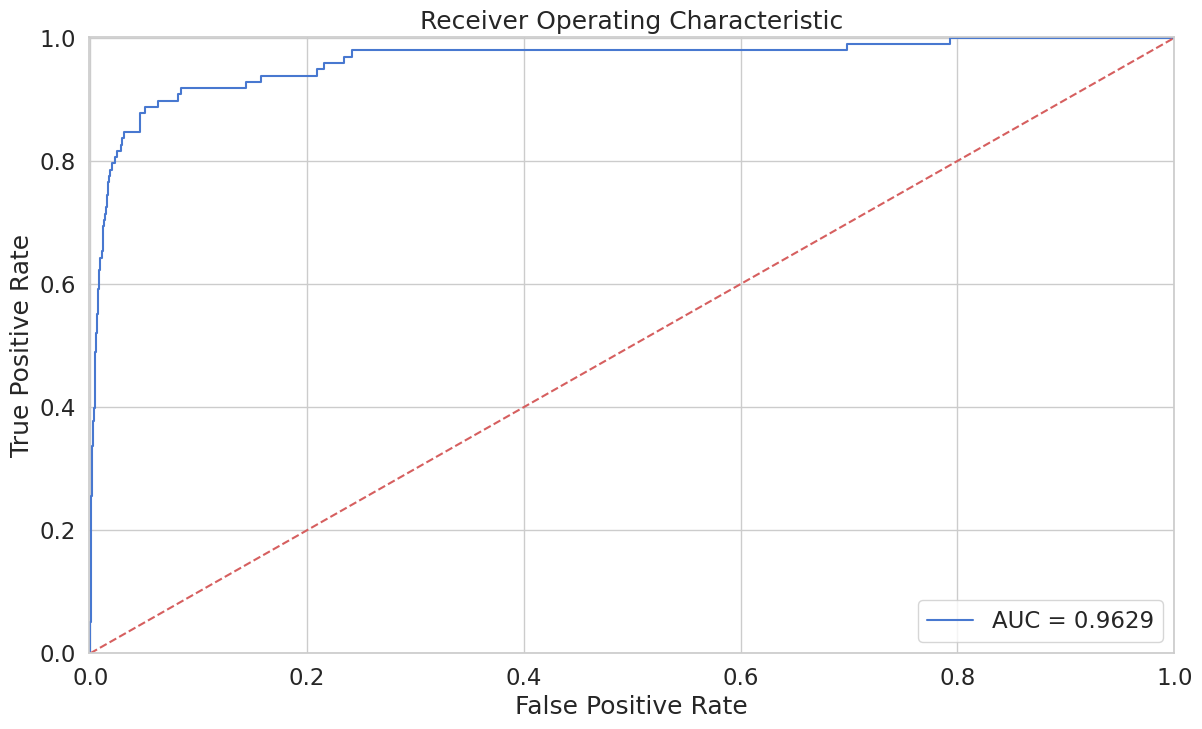

In [ ]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

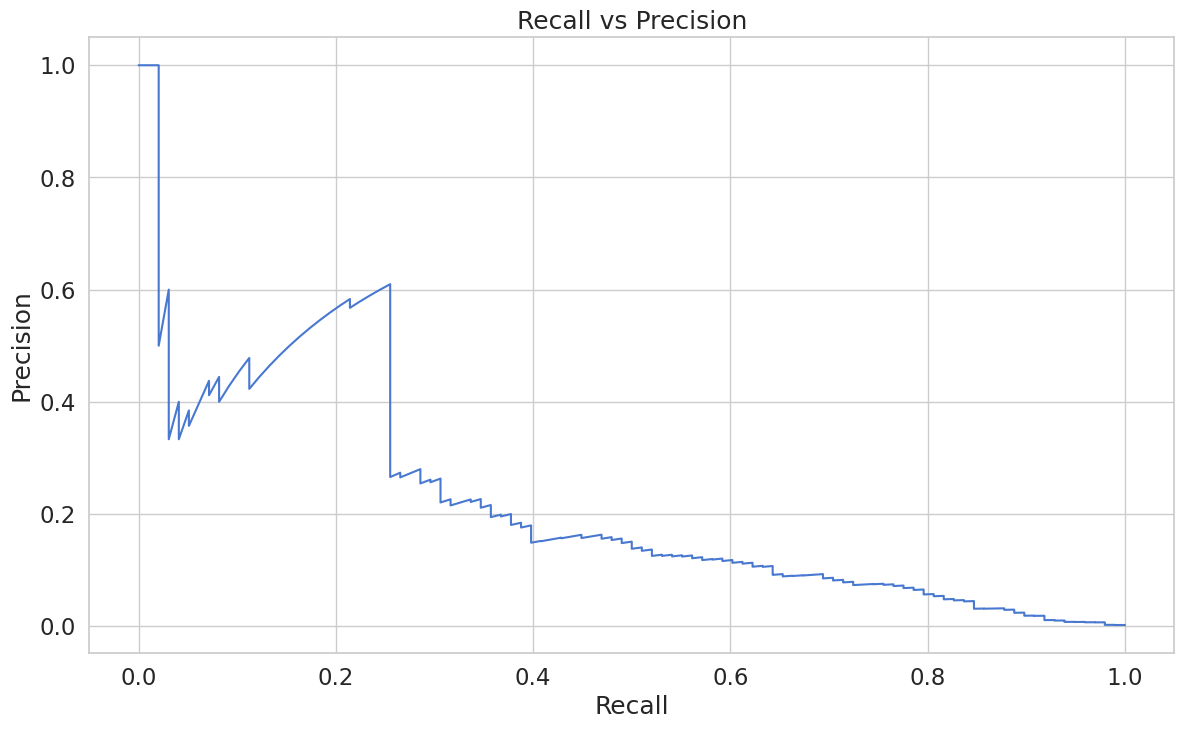

In [ ]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

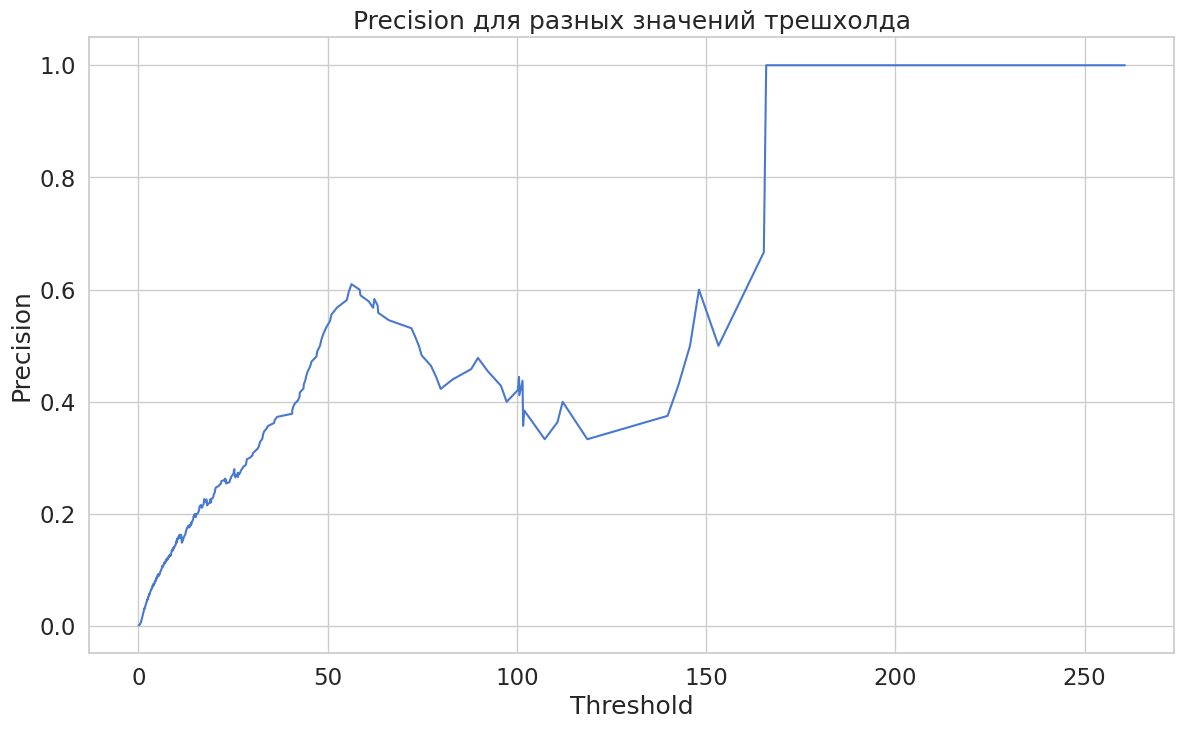

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


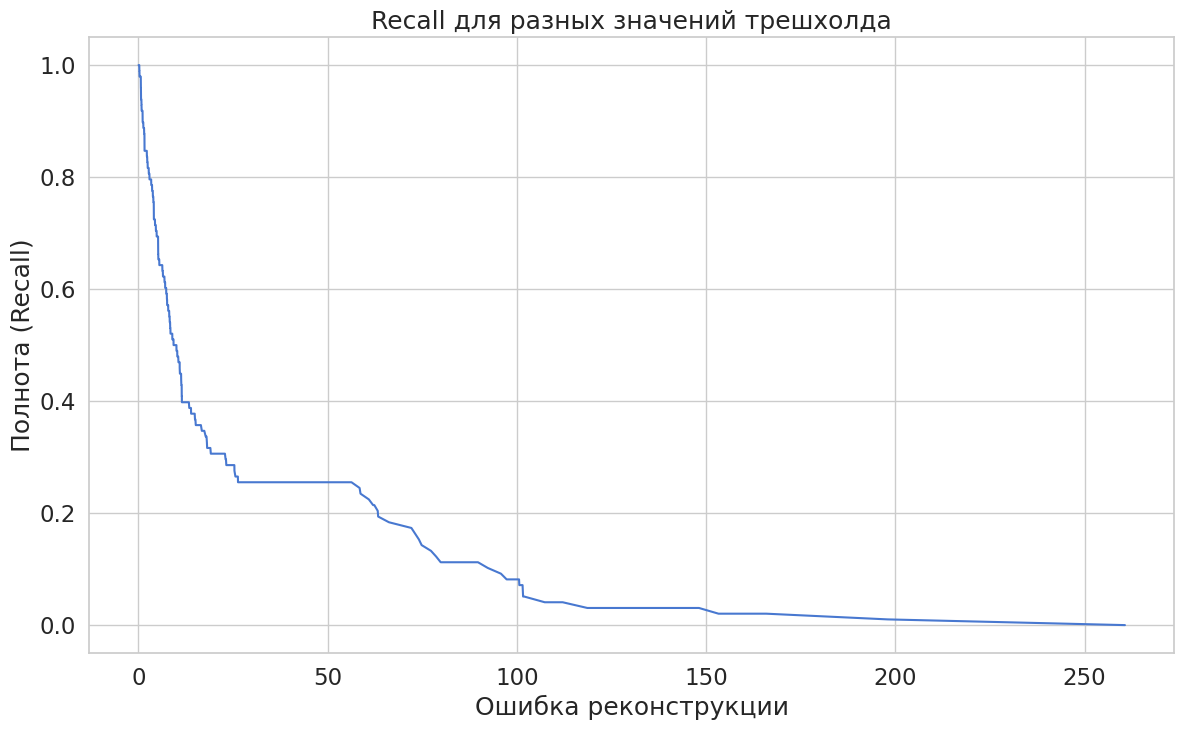

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

Чтобы предсказать, является ли новая/невидимая транзакция нормальной или мошеннической, мы рассчитаем ошибку реконструкции на основе самих данных транзакции. Если ошибка превышает предопределенный порог, мы помечаем ее как мошенничество (поскольку наша модель должна иметь низкую ошибку при обычных транзакциях). Давайте выберем это значение:

In [ ]:
threshold = 2.9

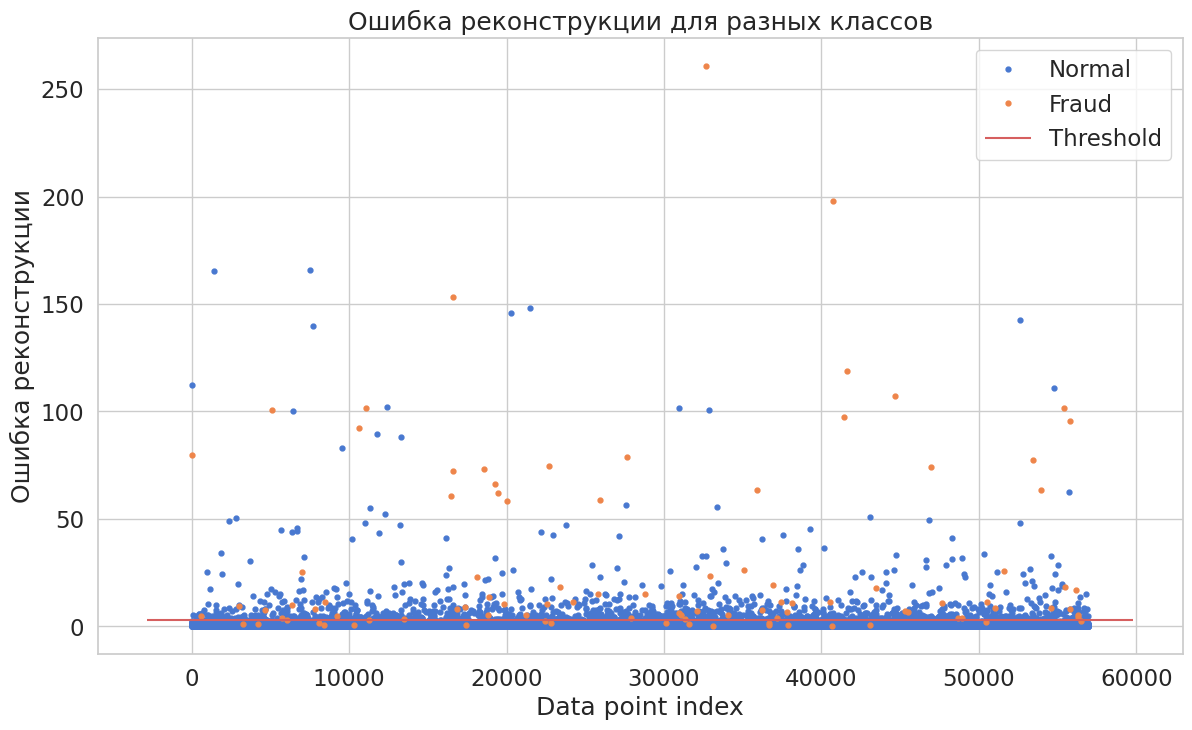

In [ ]:
groups = reconstructionErrorDF.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

<ipython-input-48-11f70cc5c840>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


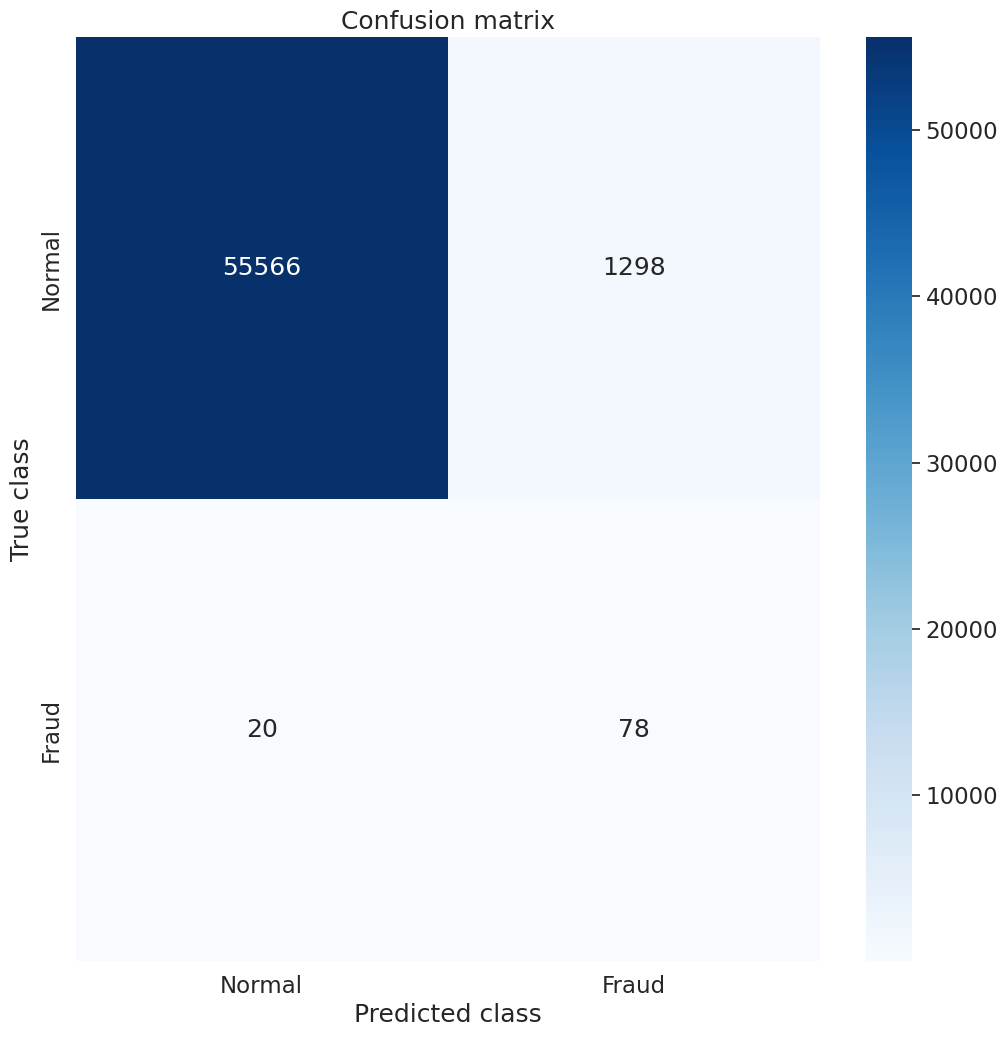

In [ ]:

y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Наша модель, похоже, выявляет множество случаев мошенничества. Но количество обычных транзакций, классифицируемых как мошенничество, действительно велико. Можно настроить порог здесь и там, чтобы получить лучшие результаты.

## Выводы


Мы создали очень простой Deep Autoencoder в PyTorch, который может реконструировать, как выглядят немошеннические транзакции. Он научился распознавать немошеннические транзакции, изучая некоторые шаблоны, присутствующие в этих транзакциях, и что это за шаблоны, о которых трудно сказать — загадка любой нейронной сети с глубоким обучением.

PyTorch предоставил нам очень понятный и простой в использовании API для создания нетривиального Deep Autoencoder. Можно попытаться создать аналогичный автоэнкодер, используя другую структуру, например Tensorflow/Keras/fast.ai, для другого домена/проблемы, например, классифицировать изображения как содержащие неприемлемый контент.